In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,classification_report,roc_curve,roc_auc_score

In [127]:
pd.set_option('display.max_columns',None)
pd.set_option('display.width',500)

When no discount is offered, and when a discount is offered based on some probability cut-off to decide who should receive a discount 20% and therefore decide where the cut-off should be set so as to maximize revenue.

In [128]:
X_test_1=pd.read_csv('./predictions_data.csv')
X_test_1.head()

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,start_year,end_year,price_p1_var_year,price_p2_var_year,price_p3_var_year,price_p1_fix_year,price_p2_fix_year,price_p3_fix_year,var_year_price_p1,var_year_price_p2,var_year_price_p3,price_p1_var_6m,price_p2_var_6m,price_p3_var_6m,price_p1_fix_6m,price_p2_fix_6m,price_p3_fix_6m,var_6m_price_p1,var_6m_price_p2,var_6m_price_p3,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,mean_dif_price_offpeak_peak_var,mean_dif_price_offpeak_peak_fix,mean_dif_price_peak_midpeak_var,mean_dif_price_peak_midpeak_fix,mean_dif_price_offpeak_midpeak__var,mean_dif_price_offpeak_midpeak__fix,max_dif_price_offpeak_peak_var,max_dif_price_offpeak_peak_fix,max_dif_price_peak_midpeak_var,max_dif_price_peak_midpeak_fix,max_dif_price_offpeak_midpeak__var,max_dif_price_offpeak_midpeak__fix,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,0,5.357685,0.000000,4.442840,3.399776,0.0,131.43,0.115939,0.100823,1.619163,0,2.456093,7.04,7.04,1,317.64,21.000,2011,2016,0.000025,8.368333e-06,2.067190e-06,0.000000,0.000000,0.000000,0.000025,8.368333e-06,0.000002,0.000011,2.943452e-06,1.435174e-06,0.000000,0.000000,0.000000,0.000011,2.943452e-06,1.435174e-06,-0.010876,0.000000,0.020414,16.291555,0.030324,8.145775,0.050738,24.437330,0.022226,16.291555,0.032070,8.145775,0.054296,24.43733,0,0,1,1,0,0,0,0.06
1,1,3.511883,3.879383,2.710963,2.570555,0.0,16.55,0.165794,0.087899,1.656207,1,1.771661,23.76,23.76,2,41.66,10.392,2012,2016,0.000006,2.667687e-07,0.000000e+00,0.006465,0.000000,0.000000,0.006470,2.667687e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,-0.004670,0.177779,0.081980,44.400265,0.088528,0.000000,0.170508,44.400265,0.084587,44.444710,0.089162,0.000000,0.172468,44.44471,0,1,0,0,1,0,0,0.01
2,2,4.048481,0.000000,0.000000,3.070692,0.0,117.17,0.115761,0.099419,1.619163,0,0.000000,22.86,22.86,1,151.23,15.935,2010,2016,0.000026,7.414530e-06,1.300205e-07,0.007038,0.002534,0.001126,0.007064,2.540921e-03,0.001126,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,-0.010689,0.162916,0.020390,16.264402,0.029113,8.132199,0.049502,24.396601,0.022581,16.291555,0.031860,8.145775,0.054441,24.43733,0,0,0,0,0,1,0,0.15
3,3,3.764998,5.008962,2.436163,2.941501,0.0,20.54,0.145884,0.000000,1.656207,1,1.614792,30.22,30.22,2,79.46,13.200,2012,2016,0.000004,0.000000e+00,0.000000e+00,0.006465,0.000000,0.000000,0.006469,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,-0.002818,0.177779,0.149965,44.400265,0.000000,0.000000,0.149965,44.400265,0.152235,44.444710,0.000000,0.000000,0.152235,44.44471,0,0,0,0,1,0,0,0.09
4,4,3.624076,0.000000,2.615950,2.631789,0.0,143.26,0.115174,0.098837,1.619163,0,1.620656,22.31,22.31,1,47.22,16.500,2010,2016,0.000095,4.435147e-05,8.033560e-04,2.008669,90.050577,40.022484,2.008764,9.005062e+01,40.023288,0.000125,4.185110e-05,9.121153e-04,2.129143,99.372856,44.165718,2.129268,9.937290e+01,4.416663e+01,-0.007801,0.162916,0.027277,20.921535,0.038835,6.771855,0.066112,27.693389,0.060550,44.266930,0.085483,8.145775,0.146033,44.26693,1,0,0,0,0,1,0,0.16


The confusion matrix in previous task shows the importance of false negatives, the most costly classification error of the model. This is when the model predicts customers stay while customers actually churn.In other words, when the model predicts customers stay, there is no need to give discount incentives for these customers.The company thereby loses profits by making them leave without doing any action for them to stay. Whereas, in terms of false positives (the model predicts customers churn while they stay), the company reduces profits by offering discounts, but still have some revenue from these returning customers. It is important, therefore, to minimize our false negative rate (or minimize costs) while maximizing true positives rate (maximize profits)

In [129]:
(X_test_1['churn_probability']>0.5).sum()


22

We assign the true negatives the cost of $0.Our model essentially correctly identified a happy customer in this case, and we won’t offer them an incentive.False negatives are the most problematic because they incorrectly predict that a churning customer will stay. We lose the customer and have to pay all the costs of acquiring a replacement customer.Finally, we give an incentive to customers that our model identifies as churning(20%). This is the cost we apply to both true positive and false positive outcomes.In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we waste the concession.

A Base Case Scenario is a hypothetical situation that defines the parameters of a business decision by accounting for expected outcomes and factors. 


Scenario analysis is a process of examining and evaluating possible events or scenarios that could take place in the future and predicting the various feasible results or possible outcomes. 

Base case scenario – It is the average scenario, based on management assumptions. An example – when calculating the net present value, the rates most likely to be used are the discount rate, cash flow growth rate, or tax rate.

Worst case scenario – Considers the most serious or severe outcome that may happen in a given situation. An example – when calculating the net present value, one would take the highest possible discount rate and subtract the possible cash flow growth rate or the highest expected tax rate.

Best case scenario – It is the ideal projected scenario and is almost always put into action by management to achieve their objectives. An example – when calculating the net present value, use the lowest possible discount rate, the highest possible growth rate, and the lowest possible tax rate

In [130]:
# For  calculating Basecase revenue i will utilize  forecast price (but only energy), but before i should reverse 
#log norm transformation which i applied on consumption features in the previous task
X_test_1['expected_revenue'] = (np.power(10, X_test_1['forecast_cons_12m']) + 1)*X_test_1['forecast_price_energy_off_peak']+X_test_1['forecast_meter_rent_12m']

 we look at only 12 months period and  i will take churn into account as well. If customers churn it also means that revenue amount of company will decrease. First month, i mean january - 1-30/365 , jan-febr 1 - 58/365, march 1- 89/365.
 
 1-30/365=1-0.082=0.918

In [131]:
#revenue * 0.918 * churn  (for january)
# revenue * (1-0.918 *churn) the rest of months ( the amount that company will lose)
X_test_1['expected_revenue_after_churn'] = X_test_1['expected_revenue'] * (1 - 0.918 * X_test_1['churn'])

In [132]:
#Difference between revenue before and after churn.(taking no account of discount)
X_test_1['expected_revenue'].sum()-X_test_1['expected_revenue_after_churn'].sum()

4116.060622205725

Get deltas or differences of revenue after  offering 20% discount.The “Delta” is gap between the current reality and  expected result and devise a technique to arrive at the goal.

In [133]:
 def revenue_deltas(pred=pd.DataFrame, cutoff=0.5, discount=0.2):
        pred['discounted_revenue'] = pred['expected_revenue_after_churn']
        pred.loc[pred['churn_probability'] >= cutoff, 'discounted_revenue'] =pred['expected_revenue'] * (1 - discount)
        pred['revenue_delta'] = pred['discounted_revenue'] -pred['expected_revenue_after_churn']
        return pred['revenue_delta'].sum()



A straightforward way to understand the impact of these numbers is to simply run a simulation over a large number of possible cutoffs.

The optimal cut-off point will balance the benefits from true positives against the costs of false positives.

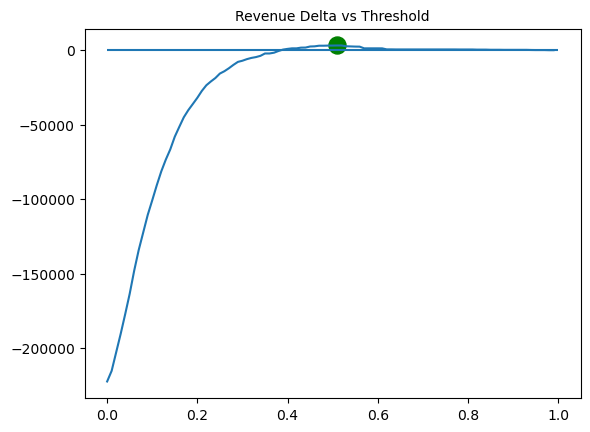

Maximum benefit at cutoff  0.51 with delta of $3,219.32


In [134]:
rev_deltas = pd.Series({cutoff: revenue_deltas(X_test_1, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas=pd.Series):
    rev_deltas.plot()
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=150, c='green')
    plt.hlines(0, 0, 1)
    plt.title('Revenue Delta vs Threshold', size = 10)
    plt.show()
    print(f'Maximum benefit at cutoff  {max_pred} with delta of ${rev_deltas.loc[max_pred]:,.2f}')
plot_tradeoff(rev_deltas)


Based on a probability cut-off  we decided who to offer the discount. But it is not always best way  because some customers may not be  high-value customers and offering them the discount decrease profit amount. Even if we only consider revenue, this strategy might not be optimal. Becaue we can calculate the expected revenue impact of our strategy and prioritise
customers for discounts that have a high expected revenue impact. This means that the
probability of churn might be high but they also might be valuable customers.İt’s worth more to the business to prevent a high spend customer from churning than a low spend customer. A very common mistake in business applications of
churn is to focus on the churn probability whilst forgetting the value impact 

In [135]:
print(round(len(X_test_1[X_test_1['expected_revenue']>700])/len(X_test_1)*100,2))

9.47


In [136]:
# I set a minimum revenue amount and based on that company  will not try to identify which customers have large revenue amount
#because our minimum is pretty high
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount:float=0.2, min_rev=700):
    pred['discount_revenue'] = pred['expected_revenue_after_churn']
    pred.loc[(pred['churn_probability'] >= cutoff) & (pred['expected_revenue']> min_rev),
             'discount_revenue'] = pred['expected_revenue'] * (1 - discount)
    pred['revenue_delta'] = pred['discount_revenue'] -pred['expected_revenue_after_churn']
    return pred['revenue_delta'].sum()


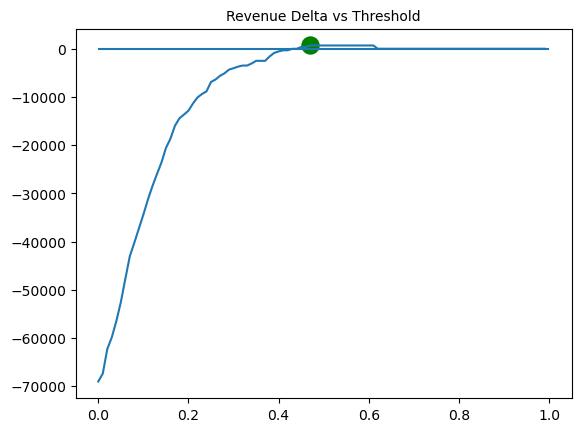

Maximum benefit at cutoff  0.47000000000000003 with delta of $680.71


In [137]:
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(X_test_1,cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas_high_value)

• Now we dont focus on large-revenue customers, because the overall
revenue delta is much lower than when targeting everyone. However, this is only the case
here since the intervention doesn’t depend on the number of customers (simply adjusting
prices). The interventions usually go beyond simply adjusting prices to prevent churn.

• There may be the option of intensifying the customer relation, adding key account managers,
or other interventions that do incur costs depending on how many customers are targeted.
In that case, it may be benefitial to target only a subset of customers to save on these costs,
even if the delta in the figure above is reduced.

Above  we offered a 20% discount to all customer targeted.
However, this might not be optimal either. We assumed before that customers offered a discount
will not churn. However, that may not be true in reality. The discount may not be large enough
to prevent churn. Thefore,we should predict
the response of customers to that discount (ie, the churn probability) based on how much that
discount affects their prices, the revenue and margin.The optimal incentives calculated here are the result of an optimization routine designed to maximize an economic figure, which is the expected total profit. Although this approach provides a principled way for marketing teams to make systematic, quantitative, and analytics-driven decisions, it’s also important to recall that the objective function to be optimized is a proxy measure to the actual total profit. It goes without saying that we can’t compute the actual profit based on future decisions (this would paradoxically imply maximizing the actual return based on future values of the stocks). But we can explore new ideas using techniques such as the potential outcomes work , which we could use to design strategies for back-testing our solution.
